In [1]:
import torch
import sys
import torch.onnx
import os
import pathlib
from  importlib import import_module
import onnx
import onnxruntime
import numpy as np
from matplotlib import pyplot as plt
from to_onnx import to_numpy

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
from misc.jp2_converter import Accessor

/usr/local/lib/python3.8/dist-packages/glymur/config.py:143: UserWarning: The openjp2 library at /workspace/lib/libopenjp2.so.2.3.1 could not be loaded.
  warnings.warn(msg, UserWarning)


glymur not setup correctly


In [3]:
datadir = '/data/special/jp2cache/'
dataname = 'B_37_FB3-SL_570-ST_NISL-SE_1708_lossless.dat'
shp = (164,164)
padding=(256-164)//2
dataname
imgaccessor=Accessor(datadir+'/'+dataname,shp,padding)

In [4]:
imgaccessor.ntiles_c, imgaccessor.ntiles_r

(498, 510)

(Extent(point1=Point(x=13238, y=32426), point2=Point(x=13494, y=32682)),
 Extent(point1=Point(x=13284, y=32472), point2=Point(x=13448, y=32636)))

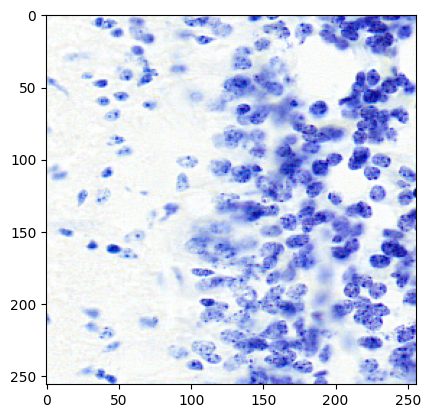

In [5]:
tilenum = 498*198+81
arr,rgn,_ = imgaccessor[tilenum]
plt.imshow(arr)
rgn,imgaccessor.get_tile_extent(tilenum)

In [31]:
inputbatch = []
inputtilenum = []
for ii in range(198,203):
    for jj in range(81,98):
        tilenum = 498*ii+jj
        arr=imgaccessor[tilenum][0].astype(np.float32)/255
        inputbatch.append(np.transpose(arr,[2,0,1]))

inputbatch = np.stack(inputbatch,axis=0)

In [32]:
inputbatch.shape

(85, 3, 256, 256)

In [33]:
inputbatch = inputbatch[:64,...]

In [9]:
# trt.volume(inputbatch.shape)/(1<<30)

In [6]:
# inputbatch = np.transpose(arr.astype(np.float32)/255,[2,0,1])[np.newaxis,...]

# torch

In [8]:
inputbatch.dtype,inputbatch.shape

(dtype('float32'), (1, 3, 256, 256))

In [9]:
device = torch.device('cpu') #'cuda:0')

In [12]:
modulename = 'monai.networks.nets'
clsname = 'HoVerNet'

mdlargs = {
    'mode':'fast',
    'in_channels':3,
    'out_classes':5,
}

mod = import_module(modulename)
cls = getattr(mod,clsname)


obj = cls(**mdlargs).to(device)
obj.eval()

mdlpath = 'weights/monai_zoo/pathology_nuclei_segmentation_classification/models/model.pt'
mdlweights = torch.load(mdlpath,map_location=device)
obj.load_state_dict(mdlweights)

out_torch = obj(torch.from_numpy(inputbatch))

dynaxes = {'input':{0:'batch_size'}}
outkeys = []
out_vals = []
for k,v in out_torch.items():
    print(k,v.shape,v.dtype)
    dynaxes[k]={0:'batch_size'}
    outkeys.append(k)
    out_vals.append(to_numpy(v))

nucleus_prediction torch.Size([1, 2, 164, 164]) torch.float32
horizontal_vertical torch.Size([1, 2, 164, 164]) torch.float32
type_prediction torch.Size([1, 5, 164, 164]) torch.float32


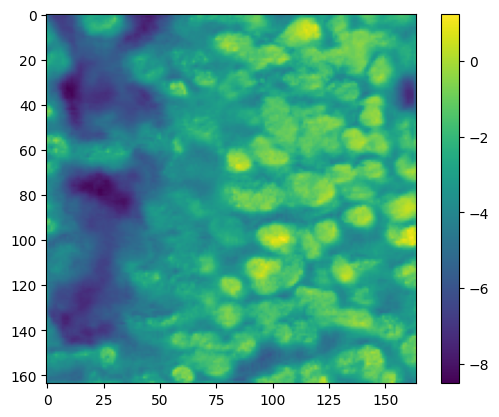

In [24]:
plt.imshow(out_vals[0][0][1,...])
plt.colorbar()

# onnx

In [2]:
onnxfile = 'weights/monai_zoo/pathology_nuclei_segmentation_classification/models/model_fp32.onnx'
onnx.checker.check_model(onnx.load(onnxfile))

In [25]:
# providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = onnxruntime.InferenceSession(onnxfile, providers= ['CPUExecutionProvider']) 

for inp in ort_session.get_inputs():
    print(inp)
    
ort_inputs = {ort_session.get_inputs()[0].name:inputbatch}
ort_outs = ort_session.run(None,ort_inputs)

for ii,out_elt in enumerate(ort_outs):
    print(out_elt.shape)
    try:
        np.testing.assert_allclose(out_elt,out_vals[ii],rtol=1e-03, atol=1e-05)
    except Exception as ex:
        print(ex)


NodeArg(name='input', type='tensor(float)', shape=['batch_size', 3, 256, 256])
(1, 2, 164, 164)
(1, 2, 164, 164)

Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 2 / 53792 (0.00372%)
Max absolute difference: 2.4389476e-05
Max relative difference: 0.42224598
 x: array([[[[ 0.023667,  0.014673,  0.011831, ...,  0.014026,  0.018092,
           0.005689],
         [ 0.01529 ,  0.000427, -0.006826, ..., -0.006804, -0.0146  ,...
 y: array([[[[ 0.023667,  0.014673,  0.011831, ...,  0.014026,  0.018092,
           0.005689],
         [ 0.01529 ,  0.000427, -0.006826, ..., -0.006802, -0.0146  ,...
(1, 5, 164, 164)


In [26]:
for inp in ort_session.get_inputs():
    print(inp)

NodeArg(name='input', type='tensor(float)', shape=['batch_size', 3, 256, 256])


In [27]:
ort_outs[0].shape

(1, 2, 164, 164)

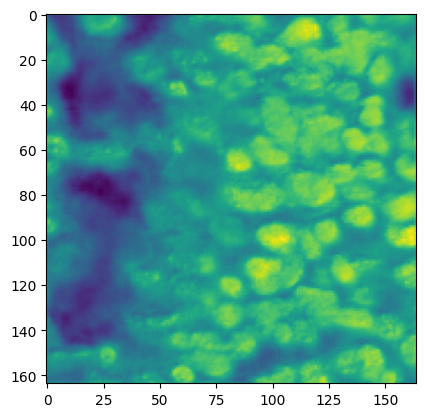

In [28]:
plt.imshow(ort_outs[0][0,1,...])

# tensorrt

In [34]:
from test_trtinfer import get_engine
import monai_infer.trt_common as common
import tensorrt as trt
from cuda import cuda,cudart
import datetime

In [35]:
batch_size = inputbatch.shape[0]

output_names = ['nucleus_prediction', 'horizontal_vertical', 'type_prediction']
output_shapes = [(2,164,164),(2,164,164),(5,164,164)]
outputspec = {nm:output_shapes[ii] for ii,nm in enumerate(output_names)}


In [36]:
cudart.cudaSetDevice(1)
engine_path = 'weights/monai_zoo/pathology_nuclei_segmentation_classification/models/engine_best.trt'
# engine_path = '/code/hbp_hover_net/weights/hovernet_256_64_best.plan'

with get_engine(engine_path) as engine, engine.create_execution_context() as context:
    print('num_bindings:',engine.num_bindings)
    print('num_optimization_profiles:',engine.num_optimization_profiles)
    common.engine_info(engine)
    
    inputs, outputs, bindings, stream, allocbatchsiz = common.allocate_buffers(engine,batch_size,0,outputspec)
    
    context.set_input_shape('input',(allocbatchsiz,3,256,256))
    
    inputs[0].host = inputbatch
    
    tic = datetime.datetime.now()
    trt_outputs = common.do_inference_v2(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
    toc = datetime.datetime.now()
    common.free_buffers(inputs, outputs, stream)

[07/14/2023-09:49:12] [TRT] [I] Loaded engine size: 38 MiB
[07/14/2023-09:49:12] [TRT] [V] Deserialization required 25721 microseconds.
[07/14/2023-09:49:12] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +1, GPU +37, now: CPU 1, GPU 7427 (MiB)
[07/14/2023-09:49:12] [TRT] [V] Total per-runner device persistent memory is 393728
[07/14/2023-09:49:12] [TRT] [V] Total per-runner host persistent memory is 390944
[07/14/2023-09:49:12] [TRT] [V] Allocated activation device memory of size 7710441472
[07/14/2023-09:49:12] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +7353, now: CPU 1, GPU 14780 (MiB)
[07/14/2023-09:49:12] [TRT] [V] CUDA lazy loading is enabled.
num_bindings: 4
num_optimization_profiles: 1
engine name Unnamed Network 0
has_implicit_batch_dimension False
num_optimization_profiles 1
max_batch_size: 1
device_memory_size: 7710441472
num_layers: 316

        input {
        name: "input"
     

In [29]:
del context

In [37]:
allocbatchsiz

64

In [17]:
toc-tic

datetime.timedelta(microseconds=131389)

In [16]:
len(trt_outputs)

3

In [12]:
trt_outputs[0].shape

(1721344,)

In [13]:
allocbatchsiz*2*164*164

1721344

In [19]:
# trt.volume(trt_outputs[0].shape)/(1<<30)

In [14]:
pred = np.reshape(trt_outputs[0],(allocbatchsiz,2,164,164))

In [15]:
type(pred)

numpy.ndarray

In [16]:
pred.shape

(32, 2, 164, 164)

In [17]:
elt = pred[0,1,...]

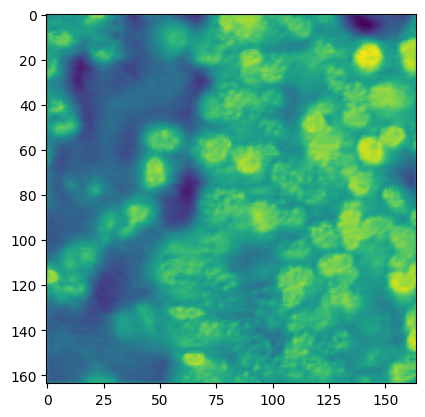

In [20]:
plt.imshow(pred[0,1,...])

In [18]:
elt.max()

1.5538663

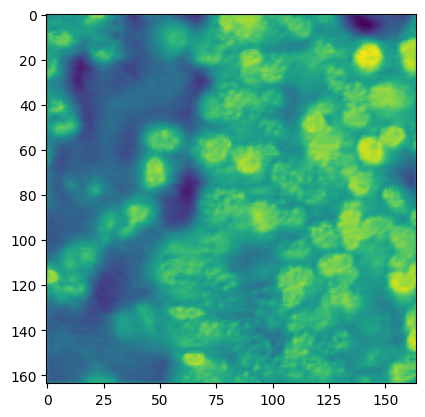

In [19]:
plt.imshow(elt)